#### Project 1 = https://www.ebi.ac.uk/pride/archive/projects/PXD002057

#### Project 2 = https://www.ebi.ac.uk/pride/archive/projects/PXD05388

#### Project 3 = https://www.ebi.ac.uk/pride/archive/projects/PXD003594

##### "Canonical" search database contains only UniProt SwissProt canonical protein sequences (Uniprot version 2023_01).

##### "trEMBL" search database includes protein isoforms and trEMBL sequences (Uniprot version 2023_01).

--------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, json, time
from matplotlib_venn import venn2, venn3
from utility_functions import *
DATE

'20250626'

In [2]:
# ID rate analysis
def read_n_MS2_spectra(filename):
    spectra_path = os.path.join(working_folder, dataset_name, 'metadata') # NO! BAD!
    json_path = os.path.join(spectra_path, filename+'-metadata.json')  
    with open(json_path) as user_file:
        parsed_json = json.load(user_file)
    for entry in parsed_json['MsData']:
        if entry["name"] == "Number of MS2 spectra":
            return int(entry['value'])
    return np.nan

def calculate_id_rates(data):
    id_rates = pd.DataFrame(data.spectrum_file.value_counts()).reset_index()
    id_rates.columns = ['spectrum_file','num_ids']
    id_rates['msms_spectra'] = id_rates.spectrum_file.apply(read_n_MS2_spectra)
    id_rates['ID_rate'] = np.round(id_rates.num_ids / id_rates.msms_spectra, 2)
    return id_rates

In [3]:
working_folder = "C:/Users/Enrico/OneDrive - UGent/run-ionbot"
PXDs = [
    "PXD002057.v0.11.4",
    "PXD005833.v0.11.4",
    "PXD014258.v0.11.4"
]
filtering_methods = [
    False,
    'global',
    'groupwalk',
    'custom'
]

project_palette

{'canon': 'orangered', 'trembl': 'yellowgreen', 'openprot': 'cornflowerblue'}

In [4]:
for dataset_name in PXDs:
    totalspectra = 0
    for file in os.scandir(os.path.join(working_folder,dataset_name,'metadata')):
        if file.name.endswith('.json'):
            # print(file)
            with open(file.path) as user_file:
                parsed_json = json.load(user_file)
            for entry in parsed_json['MsData']:
                if entry["name"] == "Number of MS2 spectra":
                    # print(int(entry['value']))
                    totalspectra += int(entry['value'])
    print(f"Total number of MS2 spectra {dataset_name[:9]} =", totalspectra)

Total number of MS2 spectra PXD002057 = 155181
Total number of MS2 spectra PXD005833 = 413900
Total number of MS2 spectra PXD014258 = 320746


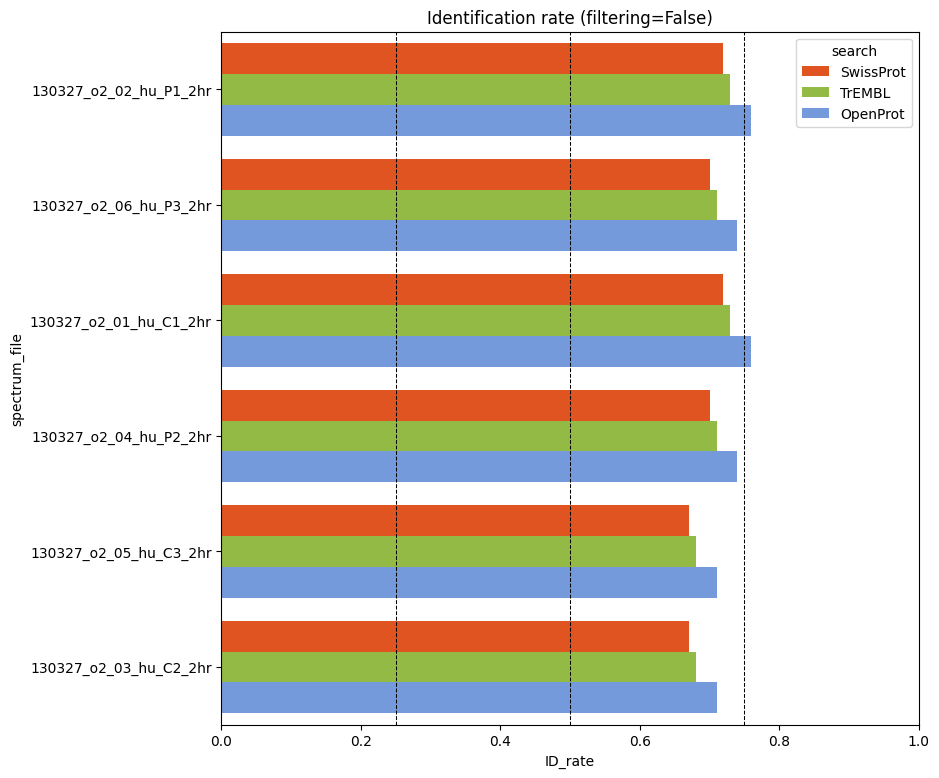

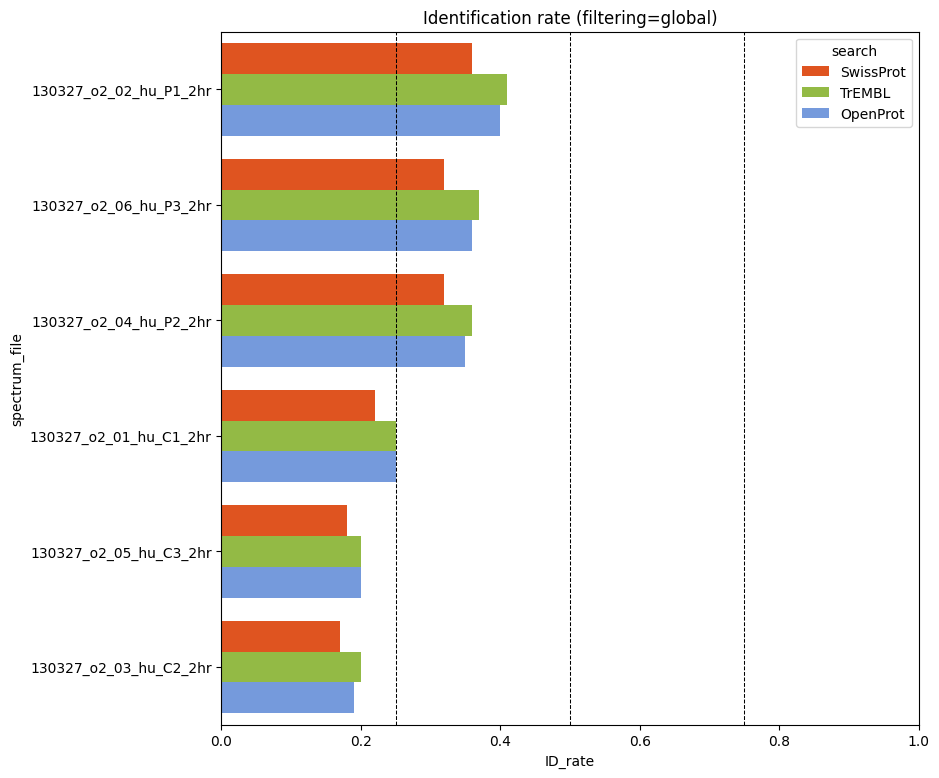

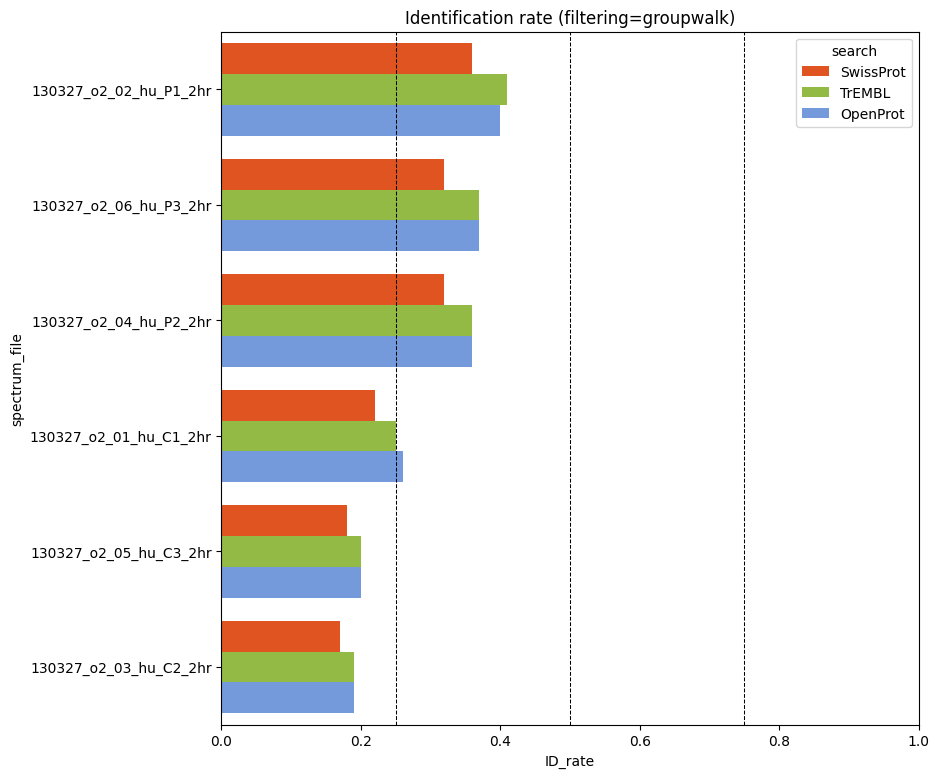

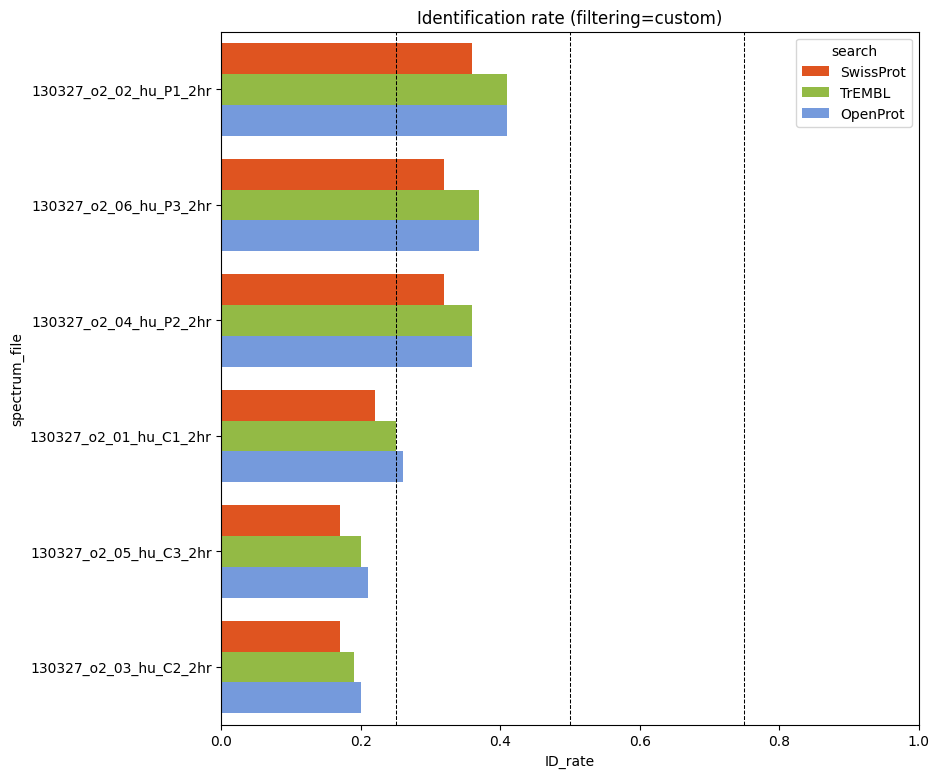

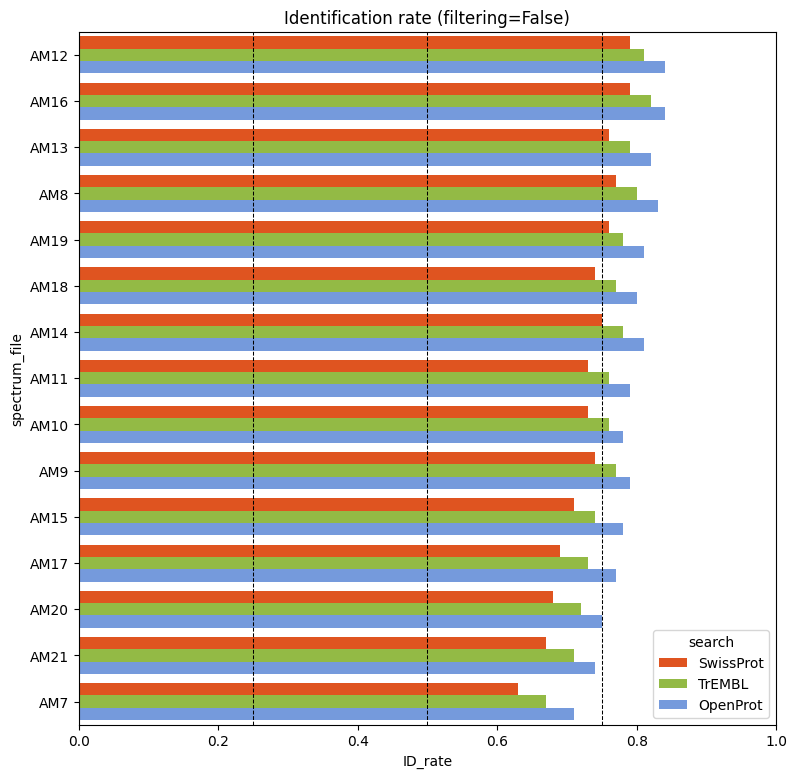

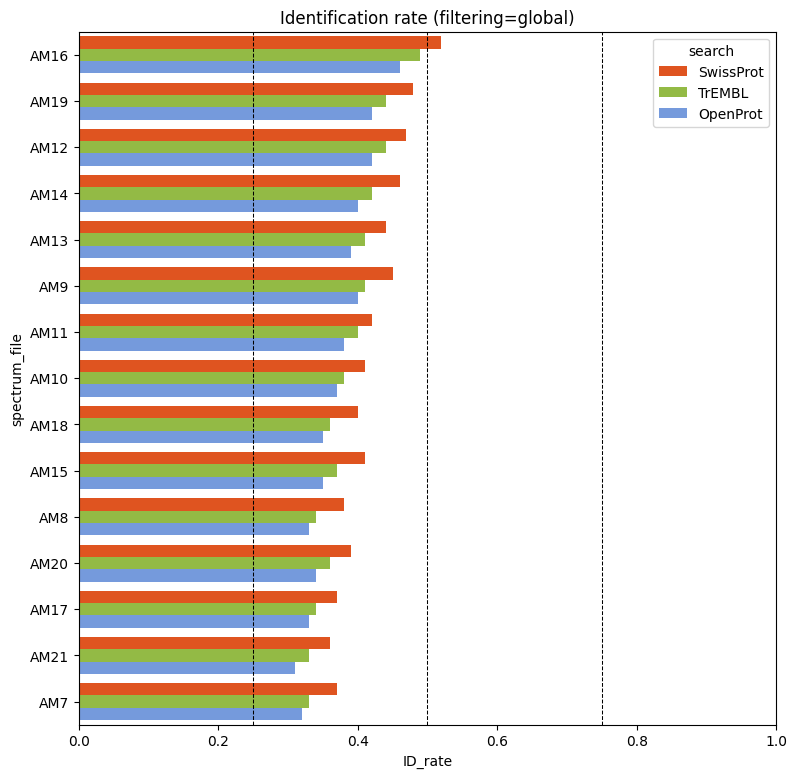

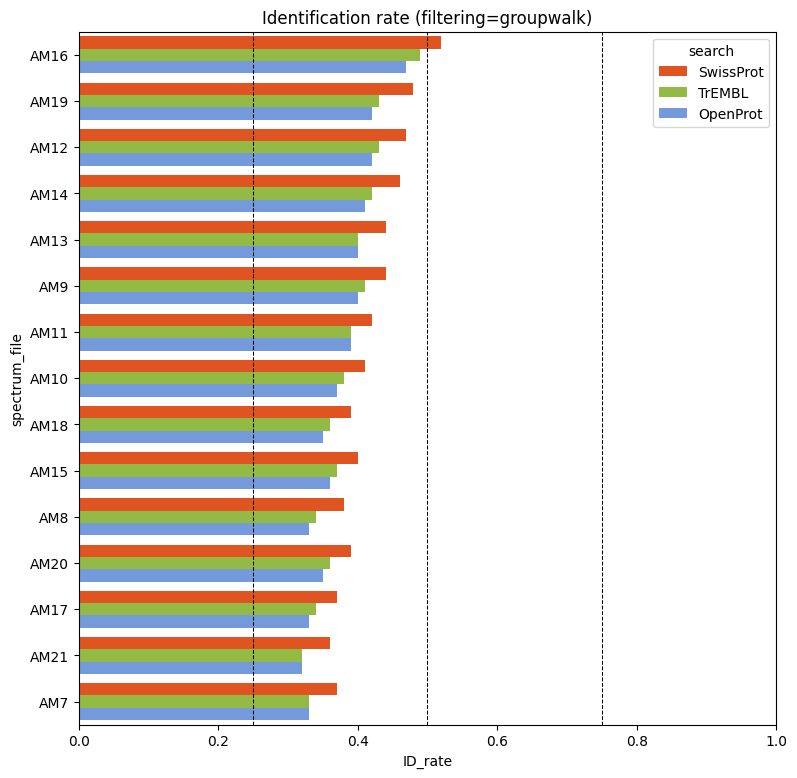

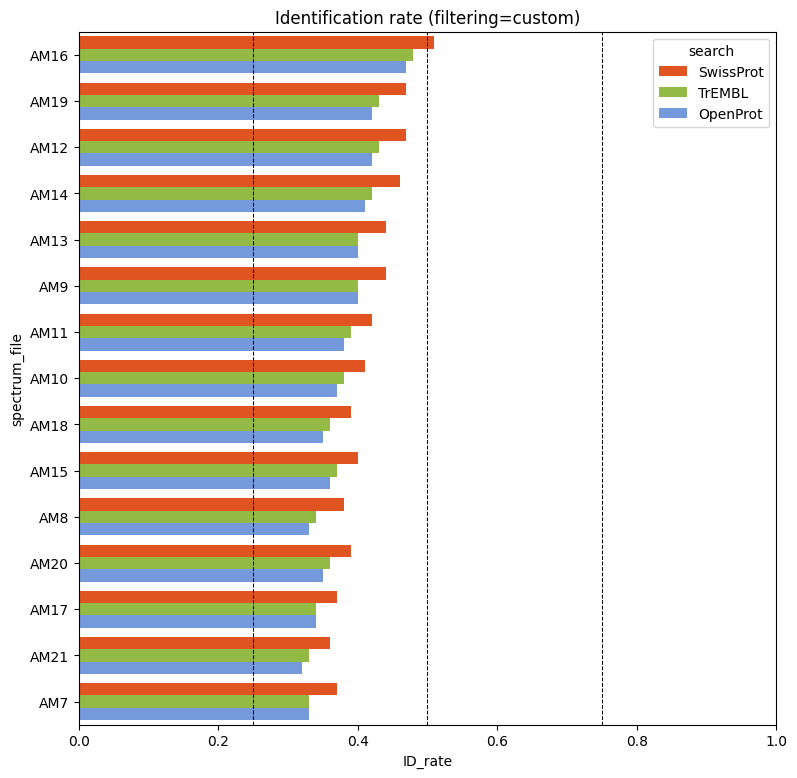

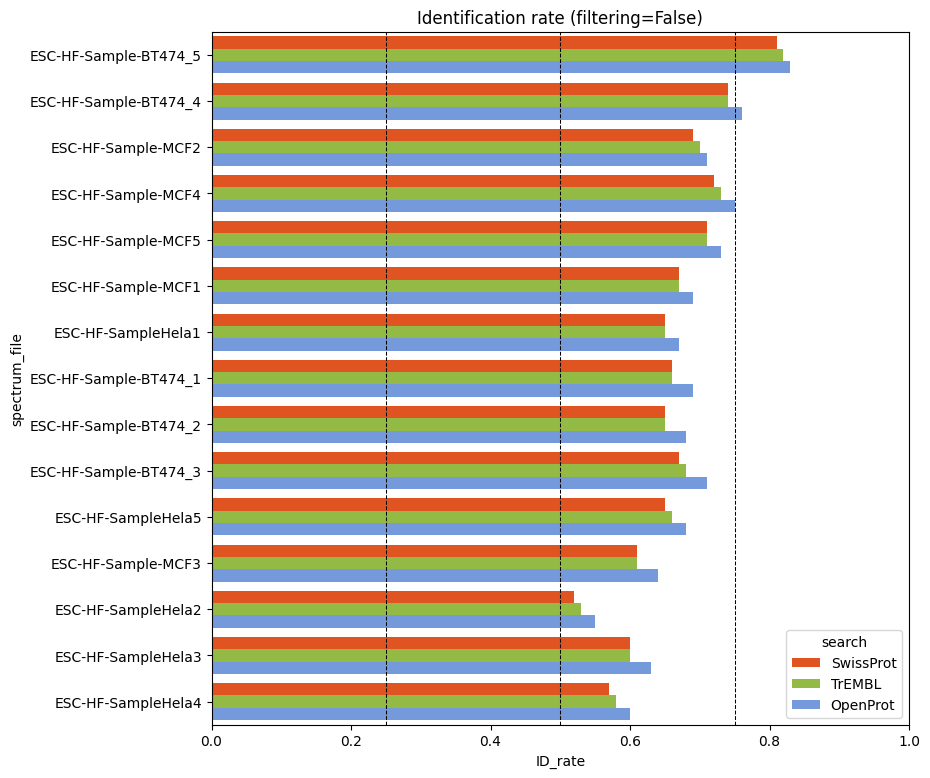

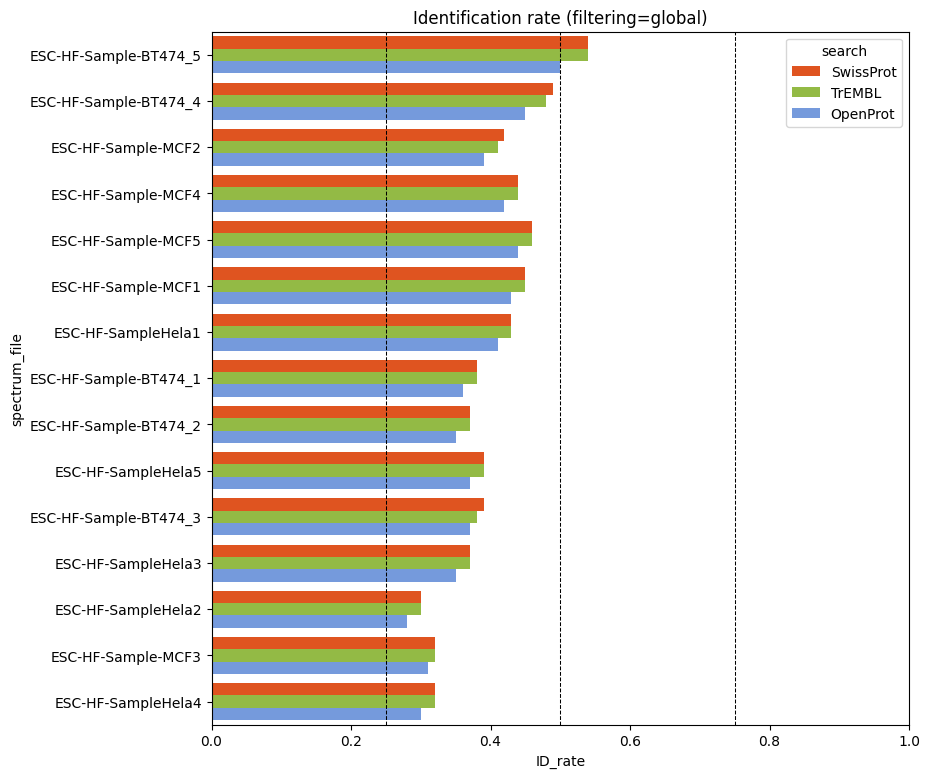

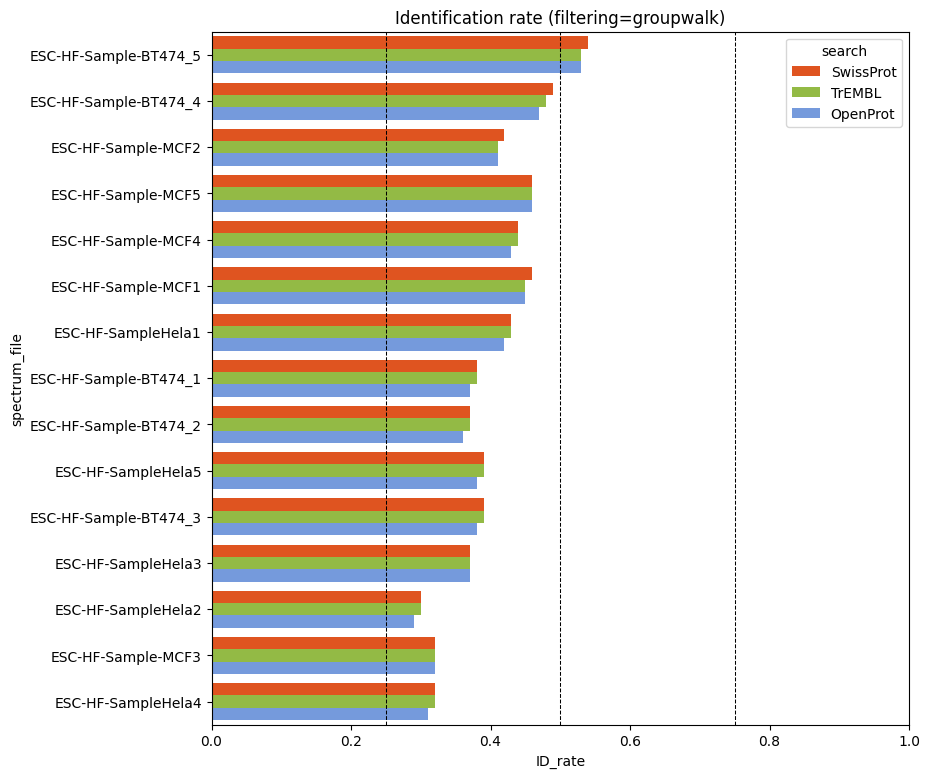

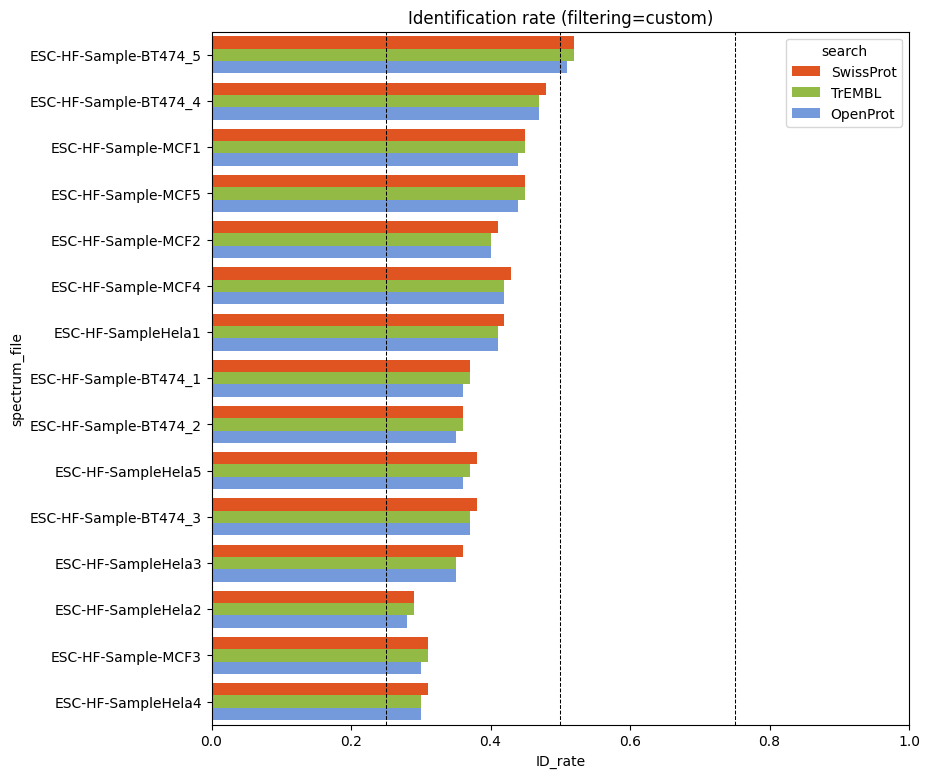

In [5]:
for dataset_name, filtering in pd.MultiIndex.from_product([PXDs,filtering_methods]):
    canonical_path = os.path.join(working_folder, dataset_name, f'{dataset_name}-canon',    "combined-results-w-qvalues.csv.gz")
    trembl_path    = os.path.join(working_folder, dataset_name, f'{dataset_name}-trembl',   "combined-results-w-qvalues.csv.gz")
    openprot_path  = os.path.join(working_folder, dataset_name, f'{dataset_name}-openprot', "combined-results-w-qvalues.csv.gz")
    
    canonical = import_pep_IDs(canonical_path, filtering=filtering)
    trembl    = import_pep_IDs(trembl_path,    filtering=filtering)
    openprot  = import_pep_IDs(openprot_path,  filtering=filtering)
    
    x1 = calculate_id_rates(canonical)
    x1['search'] = 'SwissProt'
    x2 = pd.DataFrame()
    x2 = calculate_id_rates(trembl)
    x2['search'] = 'TrEMBL'
    x3 = calculate_id_rates(openprot)
    x3['search'] = 'OpenProt'
    x = pd.concat((x1,x2,x3), ignore_index=True)
    x.to_csv(os.path.join(working_folder, dataset_name, f'ID-rate-df-filt-{filtering}.csv'), index=False)
    
    plt.figure(figsize=(9,9), facecolor='w')
    sns.barplot(data=x, y='spectrum_file', x='ID_rate', hue='search', 
                # hue_order=['Canonical','Openprot','trEMBL'], 
                palette=['orangered','yellowgreen','cornflowerblue'])
    plt.xlim(0,1)
    plt.axvline(.25, c='k', ls='--', lw=.75)
    plt.axvline(.50, c='k', ls='--', lw=.75)
    plt.axvline(.75, c='k', ls='--', lw=.75)
    plt.title(f'Identification rate (filtering={filtering})')
    plt.savefig(os.path.join(working_folder, dataset_name, f'{DATE}-ID-rate-plot-filt-{filtering}.png'), 
                dpi=300, bbox_inches='tight')

----

In [ ]:
autosave()